In [94]:
using Pkg
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("Statistics")
# Pkg.add("StaticArrays")


using Plots
using DifferentialEquations
using DataFrames
using StaticArrays
using Statistics
using Sundials
# using CairoMakie

# Cas Du modèle de Bauch

In [ ]:
function bauch!(dN,N0,param,t)
    
mu,gamma,kappa,omega,beta =param

S = N0[1]
I = N0[2]
x = N0[3]

    dN[1] = mu * (1 - x) - beta* S *I -mu*S
    dN[2] = beta* S *I - mu*I - gamma*I
    dN[3] = kappa * x * (1 -x) *(I*omega -1)

end                     
         
function bauch_triche!(dN,N0,param,t)
    
    mu,gamma,kappa,omega,beta =param
    
    S = N0[1]
    I = N0[2]
    x = N0[3]
    
        dN[1] = mu * (1 - x) - beta* S *I -mu*S - 1e-8
        dN[2] = beta* S *I - mu*I - gamma*I +  1e-8
        dN[3] = kappa * x * (1 -x) *(I*omega -1)
    
    end      



function bauch_evo!(dN,N0,param,t)

    B,d,p1,p2,d,var,gamma0,kappa,omega =param
    
    S = N0[1]
    I = N0[2]
    x = N0[3]
    
    dN[1] = B*(1-x) - d *S - trans(vir,p1,p2) * S *I
    dN[2] = trans(vir,p1,p2) * S *I - (d + vir)*I
    dN[3] = var *(trans2(vir,p1,p2) * (S + gamma0 * I) - 1 ) 
    dN[4] = kappa * x *(1 - x) * ( omega*I - 1)
    
end 

    

## Time plot

In [ ]:
tmax= 365*12*10
tspan = (0.0, tmax)
tstep = 0.001
#param
mu = 1/(365*50)
gamma = 0.1
kappa = 0.001
omega = 6000
beta = 10*(mu+gamma)
print(beta)
param = [mu ,gamma ,kappa ,omega ,beta]

S0 = 0.05
I0= 0.0001
x0 =0.95
N0 = [S0 ,I0,x0 ]

ode_bauch =  ODEProblem(bauch!,N0,tspan,param,saveat = tstep)
sol = solve(ode_bauch,Vern9(),isoutofdomain = (m,para,t) -> any(x->x<0, m),saveat=1)
sol = DataFrame(sol)
rename!(sol,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :x)


In [ ]:
# plot(sol[:,1],sol[:,2])

x = sol.time

y1 = sol.S
y2 = sol.I
y3 = sol.x

# Création du graphique
plot(x, y1, label="Sains", color="green", linewidth=2)
plot!(x, y2, label="Infectés", color="red", linewidth=2)
plot!(x, y3, label="Coopérateurs", color="blue", linewidth=2)

# Ajout du titre et des labels
title!("Dynamiques des sains, infectés et coopérateurs")
xlabel!("Temps")
ylabel!("Population")

### Diagramme de bifurcation à 2 paramètres 

In [ ]:
nbr_val =100
kappa_vec = range(0.0001,stop = 0.002,length = nbr_val)
omega_vec = range(1100,stop = 6000,length = nbr_val)

tab_res = zeros(nbr_val, nbr_val)

mu = 1/(365*50)
gamma = 0.1
beta = 10*(mu+gamma)

tmax= 365*12*200

tspan = (0.0, tmax)
tstep = 0.001
S0 = 0.1
I0= 0.01
x0 =0.95
N0 = [S0 ,I0,x0 ]


for i in 1:length(kappa_vec)
    for y in 1:length(omega_vec)
# plot(sol[:,1],sol[:,2])
#print("Parametres kappa: ",kappa," et omega: ", omega)
#param

omega = omega_vec[y]
kappa = kappa_vec[i]

param = [mu ,gamma ,kappa ,omega ,beta]



ode_bauch =  ODEProblem(bauch!,N0,tspan,param)
sol = solve(ode_bauch,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))
sol = DataFrame(sol)
rename!(sol,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :x)

nb_pas = length(sol.time)


last_10per = ( nb_pas - (round(Int,nb_pas/10)-100) : nb_pas-100)


xmin = minimum(sol.x[last_10per])

xmax = maximum(sol.x[last_10per])

if sol.I[nb_pas-100] < -1e-12
tab_res[y,i] = 4 
print(sol.I[nb_pas-100])
elseif sol.x[nb_pas-100] <0.0001 
    tab_res[y,i] = 1
elseif xmax - xmin <0.01
    tab_res[y,i] = 2
elseif xmax - xmin >0.01
    tab_res[y,i] = 3
end


    end
end



In [ ]:



custom_colors = ["purple","blue", "yellow", "red"]


heatmap(kappa_vec, omega_vec, tab_res, levels=[0,1,2,3], color=custom_colors)

xlabel!("Kappa")
ylabel!("Omega")
title!("Diagramme de bifurcation (Modèle de Bauch)")



# Cas classique 

## Défintion paramètres

In [95]:


#Paramètre 
@kwdef struct parma_evo_comp
    B::Float64 = 1.0
    d::Float64 = 1.0
    var::Float64 = 1.0
    gamma0::Float64 = 0.1
    vit1::Float64 = 50.0
    kappa::Float64 = 0.1
    p1::Float64 = 10.0
    p2::Float64 = 1.0
    trans::Float64 = 10.0
    mort::Float64 = 1.0
    param_form1::Float64 = 1.0
    param_form2::Float64 = 0.0
    rho::Float64 = 1.0
    form::Float64 = 1.0
    form_biais::String = "lineaire"
    m::Float64 = 1.0
end

param_basic = parma_evo_comp()


#Condition initiale

@kwdef struct IniV_evo_comp
    S0::Float64 = 0.9
    I0::Float64 = 0.1
    v0::Float64 = 0.5
    x0::Float64 = 0.5
    y0::SVector{3,Float64} = SVector(S0,I0,x0)
    u0::SVector{4,Float64} = SVector(S0,I0,v0,x0)
end

@show iniv = IniV_evo_comp()

# @kwdef struct IniV_comp
#     S0::Float64 = 0.9
#     I0::Float64 = 0.1
#     x0::Float64 = 0.5
#     u0::SVector{3,Float64} = SVector(S0,I0,x0)
# end

# @show iniv_comp = IniV_comp() 


@kwdef struct ParTime
    tspan::Tuple{Float64,Float64} = (0.0,2000)
    tstep::Float64 = 0.1
end

ptime =ParTime()

iniv = IniV_evo_comp() = IniV_evo_comp(0.9, 0.1, 0.5, 0.5, [0.9, 0.1, 0.5], [0.9, 0.1, 0.5, 0.5])


ParTime((0.0, 2000.0), 0.1)

### Définition des fonctions

In [96]:
# Structure de param


function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir /(vir + d))
    I_biais = I

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end



function mod_vac_comp(init::SVector{3}, p::parma_evo_comp, t)
    (;B,d,vit1,kappa,trans,mort,rho,form,m) = p

    S =init[1]
    I =init[2]
    x = init[3]

    rap_cost = kappa / (mort /(mort + d))


    dS = B*(1-x) - d *S - trans * S *I
    dI = trans * S * I - (d + mort)*I
    dx = vit1 * x *(1 - x) * ( I   - rap_cost)
    return SVector(dS,dI,dx)
end


 

function transmission(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return (p1*x^p2)
end

function transmission2(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return (p1*p2*x^(p2-1))
end


function beta1(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return ((x*p1)/(p2+x))
end

function beta2(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return ((p1*p2)/(p2+x)^2)
end


# function pi_n(v::Real,p::parma_evo_comp_h)
#     res = 1 -exp(- v  * rho)
#     return ( h_cte(res,p))
# end





beta2 (generic function with 1 method)

### Paramètres et cond initiales

### Fonction de simulation

In [97]:
function sim_mod(init ,p::parma_evo_comp ,pt::ParTime,solveur )
    (;tspan,tstep) = pt
    (; u0) = init
    
    prob_mod = ODEProblem(mod_vac_evo_comp,u0,tspan,p,saveat = tstep)
    sol_mod = solve(prob_mod,solveur,abstol = 1e-12,reltol = 1e-12)
    sol_mod = DataFrame(sol_mod)
    rename!(sol_mod,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :v, :value4 => :x)
    return sol_mod
end 




# ,isoutofdomain = (m,para,t) -> any(x->x<0, m)
function sim_mod_nocomp(init ,p::parma_evo_comp ,pt::ParTime ,solveur)
    (;tspan,tstep) = pt
    (; y0) = init
    
    prob_mod = ODEProblem(mod_vac_comp,y0,tspan,p,saveat = tstep)
    sol_mod = solve(prob_mod,solveur,abstol = 1e-12,reltol = 1e-12)
    sol_mod = DataFrame(sol_mod)
    rename!(sol_mod,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :x)
    return sol_mod
end

function diagram_bif(nbr_val::Real,pt::ParTime,solvee,val1::Float64,val2::Float64)
    kappa_vec = range(val1,stop = val2,length = nbr_val)
    vit1_vec = range(1,stop = 100,length = nbr_val)
    tab_res = zeros(nbr_val, nbr_val)

    
    
    # BOucle pour les diagrammes bif 
    for i in 1:length(kappa_vec)
        for y in 1:length(vit1_vec)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param
    
        kappa_mod = kappa_vec[i]
        vit1_mod = vit1_vec[y]
            
        param_bif = parma_evo_comp(kappa = kappa_mod,vit1 =vit1_mod,p1 = 8,p2 = 0.7) 
        sol = sim_mod(iniv,param_bif,pt,solvee)
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
                
        xmin = minimum(sol.x[last_10per])
    
        xmax = maximum(sol.x[last_10per])

        cond1 = minimum(sol.S[last_10per])
    
        cond2 = maximum(sol.S[last_10per])
    
        if sol.I[nb_pas] < -1e-12
            tab_res[y,i] = 6
            print(sol.I[nb_pas])
        elseif minimum(sol.v[nb_pas-500:nb_pas])  <0 #(sol.v[nb_pas-10] <0 && sol.v[nb_pas-25] <0 && sol.v[nb_pas] <0)
            tab_res[y,i] = 5
        elseif minimum(sol.x[nb_pas-500:nb_pas]) > 0.99999 
            tab_res[y,i] = 4
        elseif sol.x[nb_pas] <1e-12 && (xmax - xmin < 0.0001  || cond2 - cond1 < 0.0001  ) #&& sol2.x[nb_pas-1000] <1e-12 && sol2.x[nb_pas-700] <1e-12
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end

    
            end
        end
    
        return tab_res
    
end



function comparaison_diagramme_biff(nbr_val::Real,pt::ParTime,p_form1::Float64 ,p_form2::Float64)
    kappa_vec = range(0.1,stop = 0.5,length = nbr_val)
    vit1_vec = range(1,stop = 100,length = nbr_val)
    tab_res = zeros(nbr_val, nbr_val)
    tab_res2 = zeros(nbr_val, nbr_val)


# BOucle pour les diagrammes bif 
    for i in 1:length(kappa_vec)
        for y in 1:length(vit1_vec)

# plot(sol[:,1],sol[:,2])
#print("Parametres kappa: ",kappa," et omega: ", omega)
#param

        kappa_mod = kappa_vec[i]
        vit1_mod = vit1_vec[y]
        
        param_bif = parma_evo_comp(kappa = kappa_mod,vit1 =vit1_mod,p1 = 10,p2 = 0.5 ) 
        sol = sim_mod(iniv,param_bif,pt,Vern9())

        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
            
        xmin = minimum(sol.x[last_10per])

        xmax = maximum(sol.x[last_10per])

        if sol.I[nb_pas] < -1e-12
        tab_res[y,i] = 5
        elseif sol.x[nb_pas] > 0.99999
        tab_res[y,i] = 4
        elseif sol.x[nb_pas] <1e-12 && xmax - xmin < 0.0001 #&& sol.x[nb_pas-1000] <1e-12 && sol.x[nb_pas-700] <1e-12
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end



            
        vir_mean = mean(sol.v[last_10per])
        trans_mean = (param_bif.p1 *vir_mean  )/(vir_mean + param_bif.p2)

        
        param_bif2 = parma_evo_comp(kappa = kappa_mod, vit1 =vit1_mod, trans = trans_mean, mort = vir_mean ) 

        sol2 = sim_mod_nocomp(iniv ,param_bif2,ptime ,Vern9())

        # ode_bauch =  ODEProblem(bauch!,N0,tspan,p(vit1 = vit1_mod,kappa = kappa_mod))
        # sol = solve(mod_vac_evo_comp,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))
        nb_pas2 = length(sol2.time)
        last_10per2 = ( nb_pas2 - (round(Int,nb_pas2/10)) : nb_pas2)

        xmin2 = minimum(sol2.x[last_10per2])

        xmax2 = maximum(sol2.x[last_10per2])

        cond1 = minimum(sol2.S[last_10per2])

        cond2 = maximum(sol2.S[last_10per2])



        if sol2.I[nb_pas2] < -1e-12
        tab_res2[y,i] = 5
        print(sol2.I[nb_pas2])
        elseif sol2.x[nb_pas2] > 0.99999
            tab_res2[y,i] = 4
        elseif sol2.x[nb_pas2] <1e-12 && (xmax2 - xmin2 < 0.0001  || cond2 - cond1 < 0.0001  ) #&& sol2.x[nb_pas-1000] <1e-12 && sol2.x[nb_pas-700] <1e-12
            tab_res2[y,i] = 1
        elseif xmax2 - xmin2 <0.01
            tab_res2[y,i] = 2
        elseif xmax2 - xmin2 >0.01
            tab_res2[y,i] = 3
        end

        end
    end

    return tab_res, tab_res2

end


comparaison_diagramme_biff (generic function with 1 method)

#### Diagramme de bifurcation à 1 paramètre

In [98]:


function diagramme_biff_1p(nbr_val::Real,pt::ParTime)
    
    kappa_vec = range(0.01,stop = 0.99,length = nbr_val)

    tab_res = zeros(nbr_val, nbr_val)
    tab_res2 = zeros(nbr_val, nbr_val)


# BOucle pour les diagrammes bif 
    for i in 1:length(kappa_vec)

# plot(sol[:,1],sol[:,2])
#print("Parametres kappa: ",kappa," et omega: ", omega)
#param

        kappa_mod = kappa_vec[i]

        
        param_bif = parma_evo_comp(kappa = kappa_mod,vit1 =vit1_mod ) 
        sol = sim_mod(iniv,param_bif,pt,Vern9())
       
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/10)) : nb_pas)
            
        xmin = minimum(sol.x[last_10per])

        xmax = maximum(sol.x[last_10per])

        if sol.I[nb_pas] < -1e-12
            tab_res[y,i] = 4 

        elseif sol.x[nb_pas] <1e-8
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end



            
        vir_mean = mean(sol.v[last_10per])
        trans_mean = (param_bif.p1 *vir_mean  )/(vir_mean + param_bif.p2)

      
        param_bif2 = parma_evo_comp(kappa = kappa_mod, vit1 =vit1_mod, trans = trans_mean, mort = vir_mean ) 

        sol2 = sim_mod_nocomp(iniv ,param_bif2,ptime,Vern9() )

        nb_pas = length(sol2.time)
        last_10per2 = ( nb_pas - (round(Int,nb_pas/10)) : nb_pas)
        # ode_bauch =  ODEProblem(bauch!,N0,tspan,p(vit1 = vit1_mod,kappa = kappa_mod))
        # sol = solve(mod_vac_evo_comp,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))


        xmin2 = minimum(sol2.x[last_10per2])

        xmax2 = maximum(sol2.x[last_10per2])

        if sol2.I[nb_pas2] < -1e-12
            tab_res2[y,i] = 4 
        elseif sol2.x[nb_pas2] <1e-12 && sol2.x[nb_pas2-1000] <1e-12 && sol2.x[nb_pas2-700] <1e-12 && sol2.x[nb_pas2-300] <1e-12
            tab_res2[y,i] = 1
        elseif xmax2 - xmin2 <0.01
            tab_res2[y,i] = 2
        elseif xmax2 - xmin2 >0.01
            tab_res2[y,i] = 3
        end


    end

    return tab_res, tab_res2

end

diagramme_biff_1p (generic function with 1 method)

### Fonction de plot 

In [99]:
function diagramme(x,y,z,NAME::String,vec)


    custom_colors = vec


    heatmap(x, y, z, levels=[1,2,3], color=custom_colors)

    xlabel!("Coût coopération")
    ylabel!("Taux de rencontre")
    title!(NAME)
    
end

function time_plot(sol)
    x = sol.time

    y1 = sol.S
    y2 = sol.I
    y3 = sol.x

    # Création du graphique
    plt = plot(x, y1, label="Sains", color="green", linewidth=2)
    plot!(x, y2, label="Infectés", color="red", linewidth=2)
    plot!(x, y3, label="Coopérateurs", color="blue", linewidth=2)

    # Ajout du titre et des labels
    title!("Dynamiques des sains, infectés et coopérateurs")
    xlabel!("Temps")
    ylabel!("Densité")

    return plt
end




time_plot (generic function with 1 method)

### Série temporelle 

#### Absence de coopérateurs

In [100]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir /(vir + d))
    I_biais =  I

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end


mod_vac_evo_comp (generic function with 1 method)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\monau\.julia\packages\SciMLBase\3fgw8\src\integrator_interface.jl:589


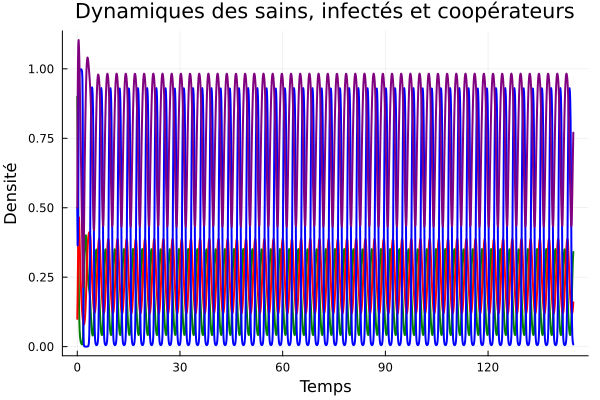

In [101]:

ptime_serie =ParTime(tspan = (0,300))
param_basic2 = parma_evo_comp(vit1 =50,kappa = 0.8,p1 = 15,p2 = 0.5,var =1.0) 
sol = sim_mod(iniv ,param_basic2 ,ptime_serie,Rosenbrock23() )

x = sol.time

y1 = sol.S
y2 = sol.I
y3 = sol.x
y4 = sol.v

# Création du graphique

plt = plot(x, y1, color="green", linewidth=2,legend = false)
plot!(x, y2,  color="red", linewidth=2)
plot!(x, y3,  color="blue", linewidth=2)
plot!(x, y4,  color="purple", linewidth=2)

# Ajout du titre et des labels
title!("Dynamiques des sains, infectés et coopérateurs")
xlabel!("Temps")
ylabel!("Densité")



#### Coopérateurs sans cycle

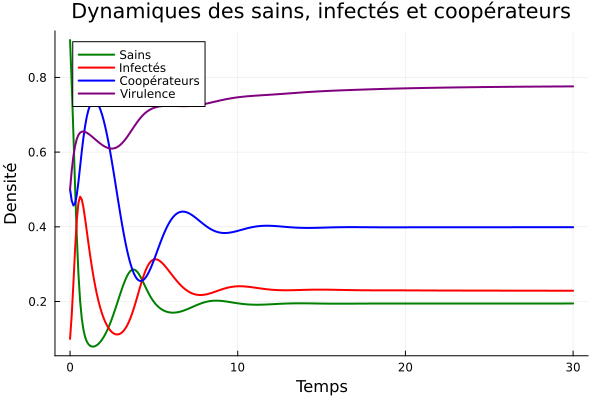

In [102]:

ptime_serie =ParTime(tspan = (0,30))
param_basic2 = parma_evo_comp(vit1 =7.5,kappa = 0.1,p1 = 15,p2 = 0.5,var =0.1) 
sol = sim_mod(iniv ,param_basic2 ,ptime_serie,Vern9() )

x = sol.time

y1 = sol.S
y2 = sol.I
y3 = sol.x
y4 = sol.v

# Création du graphique
plt = plot(x, y1, label="Sains", color="green", linewidth=2)
plot!(x, y2, label="Infectés", color="red", linewidth=2)
plot!(x, y3, label="Coopérateurs", color="blue", linewidth=2)
plot!(x, y4, label="Virulence", color="purple", linewidth=2)

# Ajout du titre et des labels
title!("Dynamiques des sains, infectés et coopérateurs")
xlabel!("Temps")
ylabel!("Densité")


#### Coopérateurs avec cycle

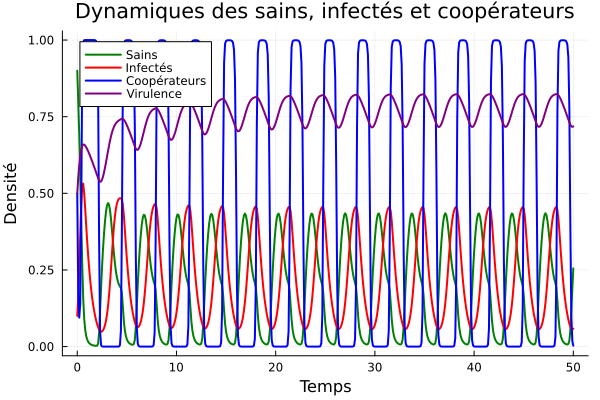

In [103]:

ptime_serie =ParTime(tspan = (0,50))
param_basic2 = parma_evo_comp(vit1 =100,kappa = 0.1,p1 = 15,p2 = 0.5,var=0.1) 
sol = sim_mod(iniv ,param_basic2 ,ptime_serie,Vern9() )

x = sol.time

y1 = sol.S
y2 = sol.I
y3 = sol.x
y4 = sol.v

# Création du graphique
plt = plot(x, y1, label="Sains", color="green", linewidth=2)
plot!(x, y2, label="Infectés", color="red", linewidth=2)
plot!(x, y3, label="Coopérateurs", color="blue", linewidth=2)
plot!(x, y4, label="Virulence", color="purple", linewidth=2)

# Ajout du titre et des labels
title!("Dynamiques des sains, infectés et coopérateurs")
xlabel!("Temps")
ylabel!("Densité")


#### Virulence

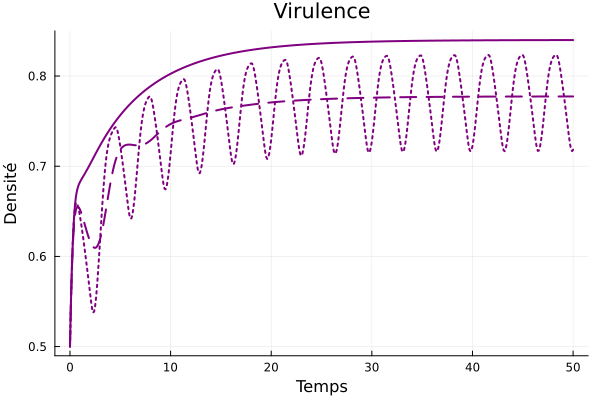

In [104]:
ptime_serie =ParTime(tspan = (0,50))
param_basic1 = parma_evo_comp(vit1 =10,kappa = 0.5,p1 = 15,p2 = 0.5,var=0.1) 

param_basic2 = parma_evo_comp(vit1 =7.5,kappa = 0.1,p1 = 15,p2 = 0.5,var=0.1) 

param_basic3 = parma_evo_comp(vit1 =100,kappa = 0.1,p1 = 15,p2 = 0.5,var=0.1) 

sol_nocoop = sim_mod(iniv ,param_basic1 ,ptime_serie,Vern9() )
sol_coop = sim_mod(iniv ,param_basic2 ,ptime_serie,Vern9() )
sol_cycle = sim_mod(iniv ,param_basic3 ,ptime_serie,Vern9() )

x = sol.time



v_nocoop = sol_nocoop.v

v_coop = sol_coop.v



v_cycle = sol_cycle.v


# Création du graphique
plt = plot(x, v_nocoop, label="no coop", color="purple", linewidth=2,linestyle = :solid,legend = false)
plot!(x, v_coop, label="coop", color="purple", linewidth=2,linestyle = :dash)
plot!(x, v_cycle, label="cycle", color="purple", linewidth=2,linestyle = :dot)

# Ajout du titre et des labels
title!("Virulence")
xlabel!("Temps")
ylabel!("Densité")

display(plt)

#### Nombre de mort

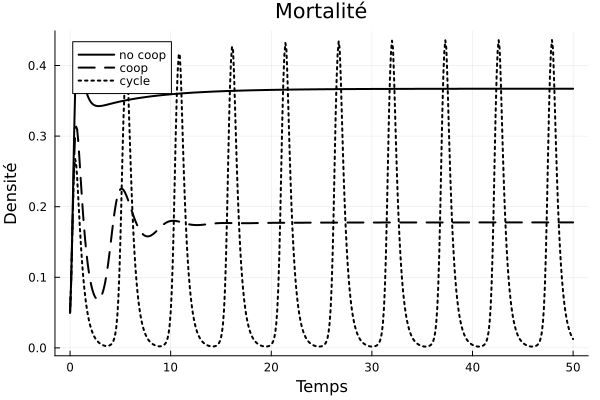

In [105]:
ptime_serie =ParTime(tspan = (0,50))
param_basic1 = parma_evo_comp(vit1 =10,kappa = 0.5,p1 = 15,p2 = 0.5,var=0.1) 

param_basic2 = parma_evo_comp(vit1 =7.5,kappa = 0.1,p1 = 15,p2 = 0.5,var=0.1) 

param_basic3 = parma_evo_comp(vit1 =100,kappa = 0.05,p1 = 15,p2 = 0.5,var=0.1) 

sol_nocoop = sim_mod(iniv ,param_basic1 ,ptime_serie,Vern9() )
sol_coop = sim_mod(iniv ,param_basic2 ,ptime_serie,Vern9() )
sol_cycle = sim_mod(iniv ,param_basic3 ,ptime_serie,Vern9() )

x = sol.time


I_nocoop = sol_nocoop.I
v_nocoop = sol_nocoop.v
nb_mort1 = v_nocoop .* I_nocoop 

I_coop = sol_coop.I
v_coop = sol_coop.v
nb_mort2 = v_coop .* I_coop 


I_cycle = sol_cycle.I
v_cycle = sol_cycle.v
nb_mort3 = v_cycle .* I_cycle 

# Création du graphique
plt = plot(x, nb_mort1, label="no coop", color="black", linewidth=2,linestyle = :solid)
plot!(x, nb_mort2, label="coop", color="black", linewidth=2,linestyle = :dash)
plot!(x, nb_mort3, label="cycle", color="black", linewidth=2,linestyle = :dot)

# Ajout du titre et des labels
title!("Mortalité")
xlabel!("Temps")
ylabel!("Densité")


#### Diagramme de bifurcation à 1 paramètres

##### Taux de rencontre selon p2

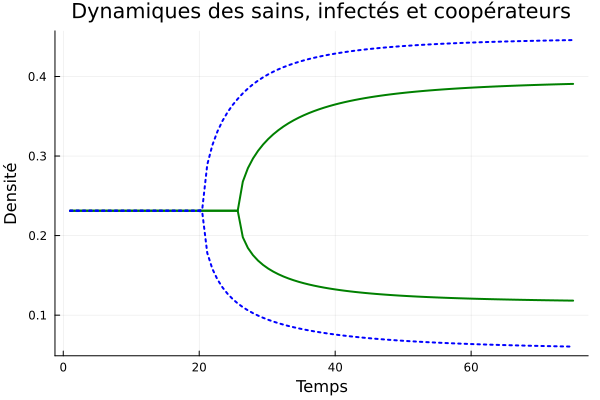

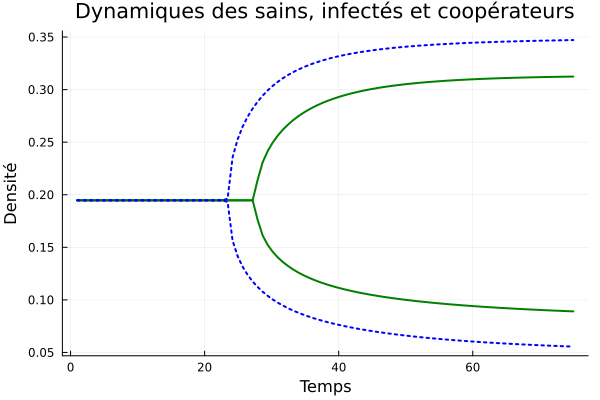

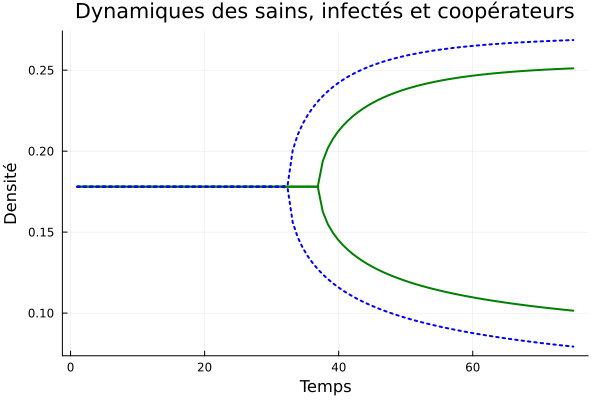

In [106]:
nbr_val =100
param1 = range(1,stop = 75,length = nbr_val)
param2 = range(0.5,stop = 1.5,length = 3)

tab_res = zeros(2, nbr_val)
tab_res2 = zeros(2, nbr_val)

ptime_bif_1 =ParTime(tspan = (0,5000))

# BOucle pour les diagrammes bif
for  y in param2
    for i in 1:length(param1)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param

        param1_mod = param1[i]
        param_bif = parma_evo_comp(vit1 = param1_mod,p1 =11.5,p2 = y) 
        sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
            
        xmin = minimum(sol.I[last_10per])

        xmax = maximum(sol.I[last_10per])

        tab_res[1,i] = xmin
        tab_res[2,i] = xmax

            
        vir_mean = mean(sol.v[last_10per])
        trans_mean = (param_bif.p1 *vir_mean  )/(vir_mean + param_bif.p2)

    
        param_bif2 = parma_evo_comp(vit1 = param1_mod,p2 = y, trans = trans_mean, mort = vir_mean ) 

        sol2 = sim_mod_nocomp(iniv ,param_bif2,ptime_bif_1,Vern9() )

        # ode_bauch =  ODEProblem(bauch!,N0,tspan,p(vit1 = vit1_mod,kappa = kappa_mod))
        # sol = solve(mod_vac_evo_comp,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))


        xmin2 = minimum(sol2.I[last_10per])

        xmax2 = maximum(sol2.I[last_10per])

        tab_res2[1,i] = xmin2
        tab_res2[2,i] = xmax2
    end

    ligne1_haut =tab_res[1,:]
    ligne1_bas =tab_res[2,:]

    ligne2_haut =tab_res2[1,:]
    ligne2_bas =tab_res2[2,:]


    # Création du graphique
    plt = plot(param1, ligne1_haut, label="complet", color="green", linewidth=2)
    plot!(param1, ligne1_bas, color="green", linewidth=2,legend = false)
    plot!(param1, ligne2_haut, label="Coopérateurs", color="blue", linewidth=2,linestyle=:dot)
    plot!(param1, ligne2_bas,  color="blue", linewidth=2,legend = false,linestyle=:dot)

    # Ajout du titre et des labels
    title!("Dynamiques des sains, infectés et coopérateurs")
    xlabel!("Temps")
    ylabel!("Densité")
    
    display(plt)
end 

##### Forme alternative

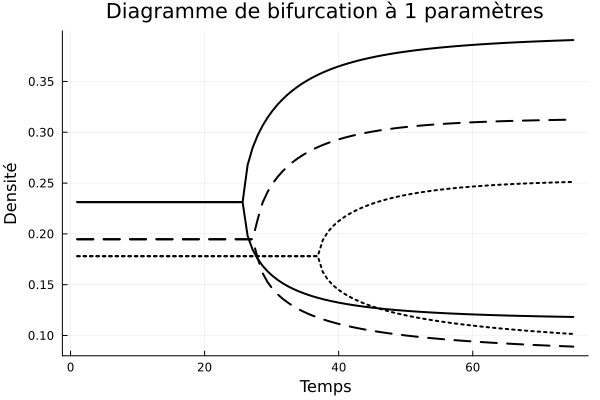

In [107]:
nbr_val =100
param1 = range(1,stop = 75,length = nbr_val)
param2 = range(0.5,stop = 1.5,length = 3)

tab_res = zeros(3, nbr_val)
tab_res2 = zeros(3, nbr_val)

ptime_bif_1 =ParTime(tspan = (0,5000))

# BOucle pour les diagrammes bif
for  y in 1:length(param2)
    for i in 1:length(param1)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param

        param1_mod = param1[i]
        param2_mod = param2[y]
        
        param_bif = parma_evo_comp(vit1 = param1_mod,p1 =11.5,p2 = param2_mod) 
        sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
            
        xmin = minimum(sol.I[last_10per])

        xmax = maximum(sol.I[last_10per])

        tab_res[y,i] = xmin
        tab_res2[y,i] = xmax

            

    end


end 

ligne1_haut =tab_res2[1,:]
ligne1_bas =tab_res[1,:]

ligne2_haut =tab_res2[2,:]
ligne2_bas =tab_res[2,:]

ligne3_haut =tab_res2[3,:]
ligne3_bas =tab_res[3,:]

# Création du graphique
plt = plot(param1, ligne1_haut, label="complet", color="black", linewidth=2)
plot!(param1, ligne1_bas, color="black", linewidth=2,legend = false)

plot!(param1, ligne2_haut, label="Coopérateurs", color="black", linewidth=2,linestyle=:dash)
plot!(param1, ligne2_bas,  color="black", linewidth=2,legend = false,linestyle=:dash)

plot!(param1, ligne3_haut, label="Coopérateurs", color="black", linewidth=2,linestyle=:dot)
plot!(param1, ligne3_bas,  color="black", linewidth=2,legend = false,linestyle=:dot)

# Ajout du titre et des labels
title!("Diagramme de bifurcation à 1 paramètres")
xlabel!("Temps")
ylabel!("Densité")

display(plt)

##### Kappa selon var

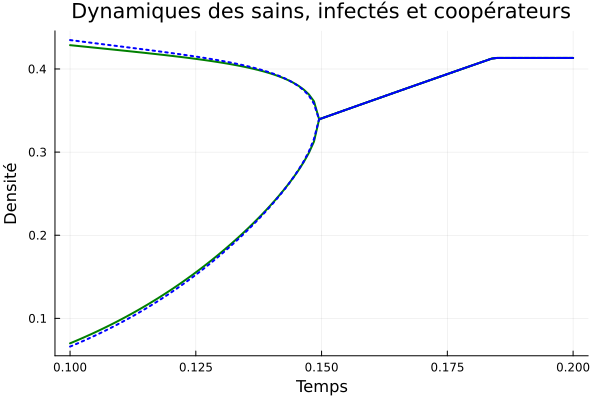

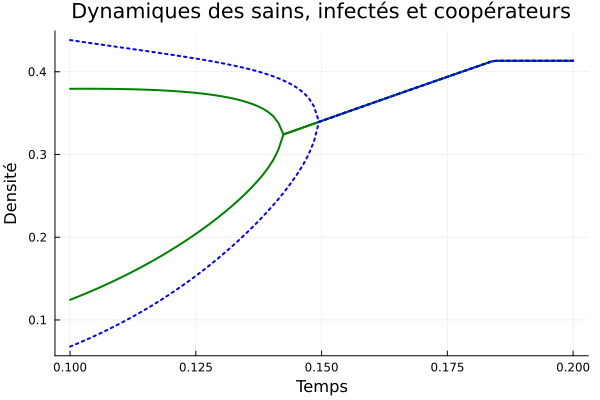

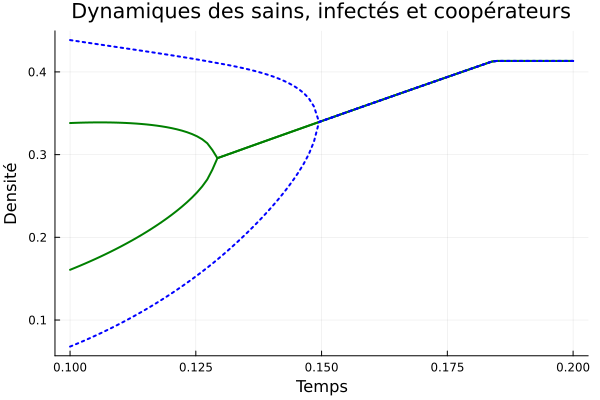

In [108]:
nbr_val =100
param1 = range(0.1,stop = 0.2,length = nbr_val)
param2 = [0.1,1.0,2.0]

tab_res = zeros(2, nbr_val)
tab_res2 = zeros(2, nbr_val)

ptime_bif_1 =ParTime(tspan = (0,5000))

# BOucle pour les diagrammes bif
for  y in param2
    for i in 1:length(param1)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param

        param1_mod = param1[i]

        # B::Float64 = 1.0
        # d::Float64 = 1.0
        # var::Float64 = 1.0
        # gamma0::Float64 = 0.1
        # vit1::Float64 = 50.0
        # kappa::Float64 = 0.1
        # p1::Float64 = 10.0
        # p2::Float64 = 1.0
        # trans::Float64 = 10.0
        # mort::Float64 = 1.0
        param_bif = parma_evo_comp(kappa= param1_mod,p1 =11.5,p2=0.5,var = y) 
        sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
            
        xmin = minimum(sol.I[last_10per])

        xmax = maximum(sol.I[last_10per])

        tab_res[1,i] = xmin
        tab_res[2,i] = xmax

            
        vir_mean = mean(sol.v[last_10per])
        trans_mean = (param_bif.p1 *vir_mean  )/(vir_mean + param_bif.p2)

    
        param_bif2 = parma_evo_comp(kappa = param1_mod,var = y, trans = trans_mean, mort = vir_mean ) 

        sol2 = sim_mod_nocomp(iniv ,param_bif2,ptime_bif_1 ,Vern9())

        # ode_bauch =  ODEProblem(bauch!,N0,tspan,p(vit1 = vit1_mod,kappa = kappa_mod))
        # sol = solve(mod_vac_evo_comp,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))


        xmin2 = minimum(sol2.I[last_10per])

        xmax2 = maximum(sol2.I[last_10per])

        tab_res2[1,i] = xmin2
        tab_res2[2,i] = xmax2
    end

    ligne1_haut =tab_res[1,:]
    ligne1_bas =tab_res[2,:]

    ligne2_haut =tab_res2[1,:]
    ligne2_bas =tab_res2[2,:]


    # Création du graphique
    plt = plot(param1, ligne1_haut, label="complet", color="green", linewidth=2)
    plot!(param1, ligne1_bas, color="green", linewidth=2,legend = false)
    plot!(param1, ligne2_haut, label="Coopérateurs", color="blue", linewidth=2,linestyle=:dot)
    plot!(param1, ligne2_bas,  color="blue", linewidth=2,legend = false,linestyle=:dot)

    # Ajout du titre et des labels
    title!("Dynamiques des sains, infectés et coopérateurs")
    xlabel!("Temps")
    ylabel!("Densité")
    
    display(plt)
end 

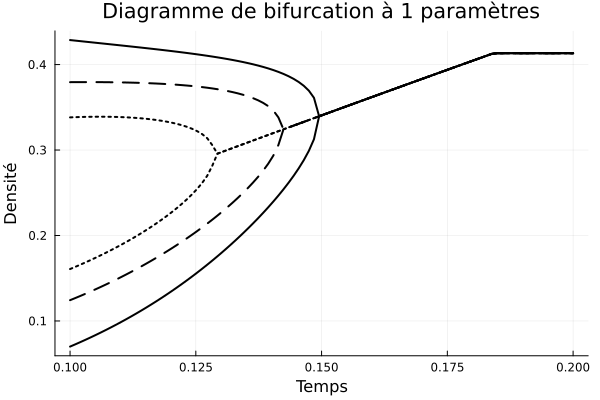

In [109]:
nbr_val =100
param1 = range(0.1,stop = 0.2,length = nbr_val)
param2 = [0.1,1.0,2.0]

tab_res = zeros(3, nbr_val)
tab_res2 = zeros(3, nbr_val)

ptime_bif_1 =ParTime(tspan = (0,5000))

# BOucle pour les diagrammes bif
for  y in 1:length(param2)
    for i in 1:length(param1)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param

        param1_mod = param1[i]
        param2_mod = param2[y]
        
        param_bif = parma_evo_comp(kappa= param1_mod,p1 =11.5,p2=0.5,var = param2_mod) 
        sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
            
        xmin = minimum(sol.I[last_10per])

        xmax = maximum(sol.I[last_10per])

        tab_res[y,i] = xmin
        tab_res2[y,i] = xmax

            

    end


end 

ligne1_haut =tab_res2[1,:]
ligne1_bas =tab_res[1,:]

ligne2_haut =tab_res2[2,:]
ligne2_bas =tab_res[2,:]

ligne3_haut =tab_res2[3,:]
ligne3_bas =tab_res[3,:]

# Création du graphique
plt = plot(param1, ligne1_haut, label="complet", color="black", linewidth=2)
plot!(param1, ligne1_bas, color="black", linewidth=2,legend = false)

plot!(param1, ligne2_haut, label="Coopérateurs", color="black", linewidth=2,linestyle=:dash)
plot!(param1, ligne2_bas,  color="black", linewidth=2,legend = false,linestyle=:dash)

plot!(param1, ligne3_haut, label="Coopérateurs", color="black", linewidth=2,linestyle=:dot)
plot!(param1, ligne3_bas,  color="black", linewidth=2,legend = false,linestyle=:dot)

# Ajout du titre et des labels
title!("Diagramme de bifurcation à 1 paramètres")
xlabel!("Temps")
ylabel!("Densité")

display(plt)

##### P1 selon gamma0

┌ Warning: At t=8.458913398960954, dt was forced below floating point epsilon 1.7763568394002505e-15, and step error estimate = 2.8678593923794486. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\monau\.julia\packages\SciMLBase\3fgw8\src\integrator_interface.jl:623
┌ Warning: At t=8.580484053855493, dt was forced below floating point epsilon 1.7763568394002505e-15, and step error estimate = 1.2227224698751924. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\monau\.julia\packages\SciMLBase\3fgw8\src\integrator_interface.jl:623
┌ Warning: At t=8.7056784613651, dt was forced below floating point epsilon 1.7763568394002505e-15, and step error estimate = 1.8890666728711154. Aborting. There is either an e

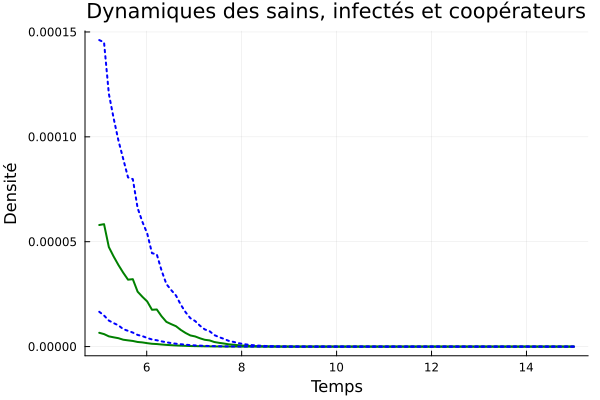

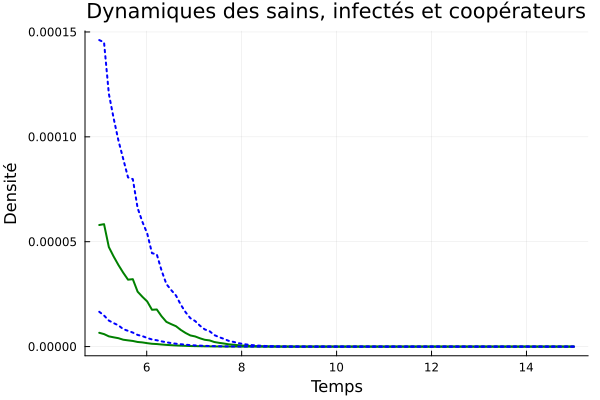

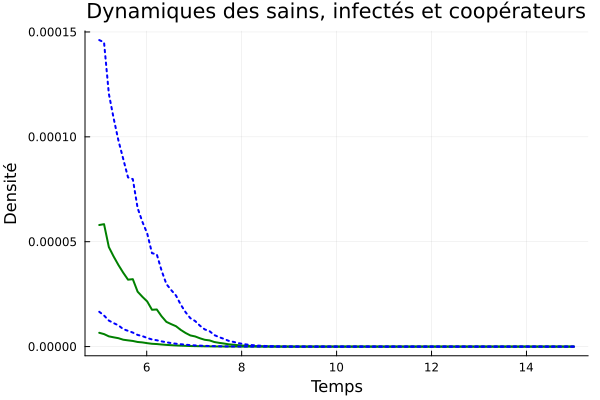

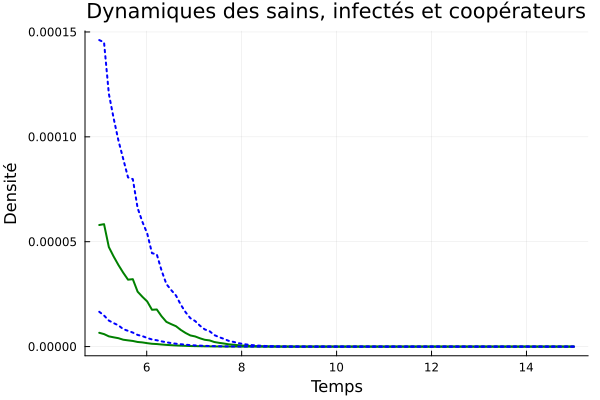

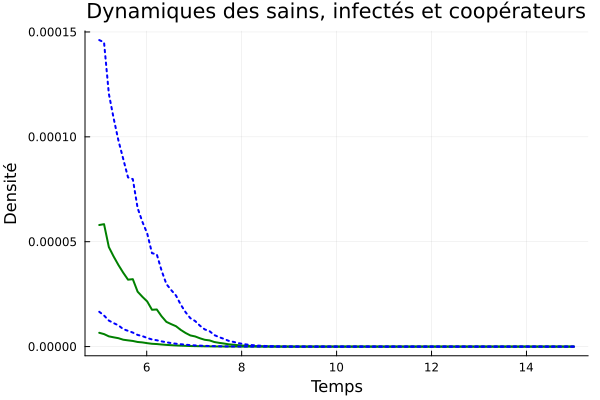

In [110]:
nbr_val =100
param1 = range(5,stop = 15,length = nbr_val)
param2 = range(0.5,stop = 5,length = 5)

tab_res = zeros(2, nbr_val)
tab_res2 = zeros(2, nbr_val)

ptime_bif_1 =ParTime(tspan = (0,2000))

# BOucle pour les diagrammes bif
for  y in param2
    for i in 1:length(param1)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param

        param1_mod = param1[i]

        # B::Float64 = 1.0
        # d::Float64 = 1.0
        # var::Float64 = 1.0
        # gamma0::Float64 = 0.1
        # vit1::Float64 = 50.0
        # kappa::Float64 = 0.1
        # p1::Float64 = 10.0
        # p2::Float64 = 1.0
        # trans::Float64 = 10.0
        # mort::Float64 = 1.0
        param_bif = parma_evo_comp(p1= param1_mod,p2 =11.5,var = 0.1) 
        sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
            
        xmin = minimum(sol.I[last_10per])

        xmax = maximum(sol.I[last_10per])

        tab_res[1,i] = xmin
        tab_res[2,i] = xmax

            
        vir_mean = mean(sol.v[last_10per])
        trans_mean = (param_bif.p1 *vir_mean  )/(vir_mean + param_bif.p2)

    
        param_bif2 = parma_evo_comp(p1= param1_mod,p2 =11.5, trans = trans_mean, mort = vir_mean ,var = 0.1) 

        sol2 = sim_mod_nocomp(iniv ,param_bif2,ptime_bif_1 ,Vern9())

        # ode_bauch =  ODEProblem(bauch!,N0,tspan,p(vit1 = vit1_mod,kappa = kappa_mod))
        # sol = solve(mod_vac_evo_comp,Vern9(),saveat=1,abstol = 1e-12,reltol = 1e-12,isoutofdomain = (m,para,t) -> any(x->x<0, m))


        xmin2 = minimum(sol2.I[last_10per])

        xmax2 = maximum(sol2.I[last_10per])

        tab_res2[1,i] = xmin2
        tab_res2[2,i] = xmax2
    end

    ligne1_haut =tab_res[1,:]
    ligne1_bas =tab_res[2,:]

    ligne2_haut =tab_res2[1,:]
    ligne2_bas =tab_res2[2,:]


    # Création du graphique
    plt = plot(param1, ligne1_haut, label="complet", color="green", linewidth=2)
    plot!(param1, ligne1_bas, color="green", linewidth=2,legend = false)
    plot!(param1, ligne2_haut, label="Coopérateurs", color="blue", linewidth=2,linestyle=:dot)
    plot!(param1, ligne2_bas,  color="blue", linewidth=2,legend = false,linestyle=:dot)

    # Ajout du titre et des labels
    title!("Dynamiques des sains, infectés et coopérateurs")
    xlabel!("Temps")
    ylabel!("Densité")
    
    display(plt)
end 

#### Diagramme de bifurcation à 2 paramètres

In [111]:
nbr_val = 20

Z = diagram_bif(nbr_val,ptime,Vern9(),0.1,0.9 )
x = range(0.1,stop = 0.9,length = nbr_val)
y = range(1,stop = 100,length = nbr_val)
diagramme(x,y,Z)

MethodError: MethodError: no method matching diagramme(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::Matrix{Float64})
The function `diagramme` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  diagramme(::Any, ::Any, ::Any, !Matched::String, !Matched::Any)
   @ Main c:\Users\monau\Desktop\THESE\Scientifique\git_hub\Newborn_vaccination_evo_behavior_model\Julia\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X26sZmlsZQ==.jl:1


### COmparaison diagrammes bif à 2 param

In [112]:
nbr_val = 100
ptime_bif_2 =ParTime(tspan = (0,2000))
Z1,Z2 = comparaison_diagramme_biff(nbr_val,ptime_bif_2,1.0,0.0)


([2.0 2.0 … 1.0 1.0; 2.0 2.0 … 1.0 1.0; … ; 3.0 3.0 … 1.0 1.0; 3.0 3.0 … 1.0 1.0], [2.0 2.0 … 1.0 1.0; 2.0 2.0 … 1.0 1.0; … ; 3.0 3.0 … 1.0 1.0; 3.0 3.0 … 1.0 1.0])

In [113]:
x = range(0.1,stop = 0.5,length = nbr_val)
y = range(1,stop = 100,length = nbr_val)
plt1 = diagramme(x,y,Z1)
plt2 = diagramme(x,y,Z2)

display(plt1)
display(plt2)

MethodError: MethodError: no method matching diagramme(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::Matrix{Float64})
The function `diagramme` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  diagramme(::Any, ::Any, ::Any, !Matched::String, !Matched::Any)
   @ Main c:\Users\monau\Desktop\THESE\Scientifique\git_hub\Newborn_vaccination_evo_behavior_model\Julia\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X26sZmlsZQ==.jl:1


# Diagramme de bifurcation selon fonction de h de lien

#### Méthodes disponnibles
QBDF2()
Rosenbrock23()
MEBDF2()
Exp4()
EXPRB53s3()
HochOst4()
CVODE_BDF()
Vern9()

### Uniquement pour cas complexe

In [114]:
function sim_mod(init::Vector{Float64} ,p::parma_evo_comp ,pt::ParTime,solvee )
    (;tspan,tstep) = pt
    (; u0) = init
    
    prob_big = ODEProblem(mod_vac_evo_comp,u0,tspan,p,saveat = tstep)
    # prob_big = remake(prob_mod, u0=BigFloat.(prob_mod.u0), p=BigFloat.(prob_mod.p))

    sol_mod = solve(prob_big,solvee,abstol = 1e-20,reltol = 1e-20, maxiters=1e8)
    sol_mod = DataFrame(sol_mod)
    rename!(sol_mod,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :v, :value4 => :x)
    return sol_mod
end
# ,isoutofdomain = (m,para,t) -> any(x->x<0, m)
function sim_mod_nocomp(init ,p::parma_evo_comp ,pt::ParTime )
    (;tspan,tstep) = pt
    (; y0) = init
    
    prob_mod = ODEProblem(mod_vac_comp,y0,tspan,p,saveat = tstep)
    sol_mod = solve(prob_mod,abstol = 1e-8,reltol = 1e-12)
    sol_mod = DataFrame(sol_mod)
    rename!(sol_mod,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :x)
    return sol_mod
end


sim_mod_nocomp (generic function with 2 methods)

In [115]:
function diagram_bif(nbr_val::Real,pt::ParTime,solvee,val1::Float64,val2::Float64)
    kappa_vec = range(val1,stop = val2,length = nbr_val)
    vit1_vec = range(1,stop = 100,length = nbr_val)
    tab_res = zeros(nbr_val, nbr_val)

    
    
    # BOucle pour les diagrammes bif 
    for i in 1:length(kappa_vec)
        for y in 1:length(vit1_vec)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param
    
        kappa_mod = kappa_vec[i]
        vit1_mod = vit1_vec[y]
            
        param_bif = parma_evo_comp(kappa = kappa_mod,vit1 =vit1_mod,p1 = 8,p2 = 0.9,var =0.1) 
        sol = sim_mod(iniv,param_bif,pt,solvee)
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
                
        xmin = minimum(sol.x[last_10per])
    
        xmax = maximum(sol.x[last_10per])

        cond1 = minimum(sol.S[last_10per])
    
        cond2 = maximum(sol.S[last_10per])
    
        if sol.I[nb_pas] < -1e-8
            tab_res[y,i] = 6
            print(sol.I[nb_pas])
        elseif minimum(sol.v[nb_pas-500:nb_pas])  <-1e-8 #(sol.v[nb_pas-10] <0 && sol.v[nb_pas-25] <0 && sol.v[nb_pas] <0)
            tab_res[y,i] = 5
        elseif minimum(sol.x[nb_pas-500:nb_pas]) > 0.99999 
            tab_res[y,i] = 4
        elseif sol.x[nb_pas] <1e-12 && (xmax - xmin < 0.0001  || cond2 - cond1 < 0.0001  ) #&& sol2.x[nb_pas-1000] <1e-12 && sol2.x[nb_pas-700] <1e-12
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end

    
            end
        end
    
        return tab_res
    
end

diagram_bif (generic function with 1 method)

## Cas classique cout percu constant

#### Absence biais ds info

On prends r(I,v) = cte et pas de



In [116]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / ((vir)/(d + vir))
    I_biais = I

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

mod_vac_evo_comp (generic function with 1 method)

In [ ]:
nbr_val = 200
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.5)
# QBDF2
#form,form_biais


# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.4, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Absence de biais d'info",["blue", "yellow","red"])


display(plt1)

#### Scénario 1/2 sur et sous estimation

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / ((vir)/(d + vir))
    I_biais = 1 - exp(-5*I)

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.5)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.5, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Absence de biais d'info",["blue", "yellow","red"])



display(plt1)


In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / ((vir)/(d + vir))
    I_biais = I^2

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.4)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red"])


display(plt1)


#### Scénario 3/4 Biais évolue 

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / ((vir)/(d + vir))
    I_biais =  1 / (1 + exp(10*(-I+0.5)))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50


ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.4)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous/Sur",["blue", "yellow","red"])

display(plt1)




In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / ((vir)/(d + vir))
    I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end


nbr_val = 50


ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.4   )
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sur/Sous",["blue", "yellow","red"])

display(plt1)


## Proba d'avoir une commorbidité selon virulence

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 200
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.01, stop=0.9, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Absence de biais ",["blue", "yellow","red","orange"])


display(plt1)

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 200
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.01, stop=0.9, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Absence de biais ",["blue", "yellow","red","orange"])


display(plt1)

In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( I^2 - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.99)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow"])


display(plt1)

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( 1 / (1 + exp(10*(-I+0.5)))  - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.99   )
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous / Sur ",["blue", "yellow"])


display(plt1)



In [ ]:



function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2  - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.1,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.4, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sur puis Sous")


display(plt1)


In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 - exp(- vir  * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

## Proba d'avoir une commorbidité selon mortalité

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.9, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"simple")


display(plt1)


In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  1 - exp(-5*I)  - rap_cost)
    return SVector(dS,dI,dv,dx)
end
#1 / (1 + exp(10*(-I+0.5)))

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.4, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Surestimation",["blue", "yellow","red","orange"])


display(plt1)

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( 1 / (1 + exp(10*(-I+0.5)))  - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.99   )
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous / Sur ",["blue"])


display(plt1)


In [ ]:





function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2  - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.4, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sur puis Sous")


display(plt1)


In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2  - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.05,0.9)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.9, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sur puis Sous")


display(plt1)


In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ (1 -exp(- vir* I * rho))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( I^2 - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.8)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue"])


display(plt1)

In [ ]:
using Plots

vec_x = range(0, stop=1, length=1000)
vec_y = similar(vec_x)  # Crée un vecteur de la même taille pour stocker les valeurs de y
vec_y2 = similar(vec_x)

for i in eachindex(vec_x)
    I = vec_x[i]
    y = 1 / (1 + exp(10*(-I+0.5)))
    y2 = I^2
    vec_y[i] = y
    vec_y2[i] = y2
end

plot(vec_x, vec_x, label="Sains", color="green", linewidth=2)
plot!(vec_x, vec_y, label="Sains", color="green", linewidth=2)
plot!(vec_x, vec_y2, label="Sains", color="green", linewidth=2)

In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,a,b) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]
    rap_cost = kappa/ ((vir)/(d + vir))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * ( I^2 - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result = diagram_bif(nbr_val, ptime_bif_2,Vern9(),0.01,0.99)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result
println("Résultat brut: ", result)
println("Type de résultat: ", typeof(result))
    

Z1 = result  # Maintenant on est sûr que result est un tuple
    
x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red","orange"])


display(plt1)


Diagramme de bif 2d +virulence max

In [ ]:
function diagram_bif_vir(nbr_val::Real,pt::ParTime,solvee,val1::Float64,val2::Float64)
    kappa_vec = range(val1,stop = val2,length = nbr_val)
    vit1_vec = range(1,stop = 100,length = nbr_val)
    tab_res = zeros(nbr_val, nbr_val)
    heatmap_vir = zeros(nbr_val, nbr_val)

    
    
    # BOucle pour les diagrammes bif 
    for i in 1:length(kappa_vec)
        for y in 1:length(vit1_vec)

    # plot(sol[:,1],sol[:,2])
    #print("Parametres kappa: ",kappa," et omega: ", omega)
    #param
    
        kappa_mod = kappa_vec[i]
        vit1_mod = vit1_vec[y]
            
        param_bif = parma_evo_comp(kappa = kappa_mod,vit1 =vit1_mod,p1 = 15,p2 = 0.5,var =0.1) 
        sol = sim_mod(iniv,param_bif,pt,solvee)
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
                
        xmin = minimum(sol.x[last_10per])
    
        xmax = maximum(sol.x[last_10per])

        cond1 = minimum(sol.S[last_10per])
    
        cond2 = maximum(sol.S[last_10per])
    
        if sol.I[nb_pas] < -1e-8
            tab_res[y,i] = 6
            print(sol.I[nb_pas])
        elseif minimum(sol.v[nb_pas-500:nb_pas])  <0 #(sol.v[nb_pas-10] <0 && sol.v[nb_pas-25] <0 && sol.v[nb_pas] <0)
            tab_res[y,i] = 5
        elseif minimum(sol.x[nb_pas-500:nb_pas]) > 0.99999 
            tab_res[y,i] = 4
        elseif sol.x[nb_pas] <1e-12 && (xmax - xmin < 0.0001  || cond2 - cond1 < 0.0001  ) #&& sol2.x[nb_pas-1000] <1e-12 && sol2.x[nb_pas-700] <1e-12
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end

        heatmap_vir[y,i] = maximum(sol.v[nb_pas-500:nb_pas])



            end
        end
    


        return tab_res, heatmap_vir
    
end

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir/(vir + d))
    I_biais = I

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 200
ptime_bif_2 = ParTime(tspan = (0, 4000))

born_inf = 0.01
born_supp = 0.3

result,vir_tab = diagram_bif_vir(nbr_val, ptime_bif_2,Vern9(),born_inf,born_supp)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result

    

Z1 = result  # Maintenant on est sûr que result est un tuple
Z2 = vir_tab
println("result")
println(typeof(Z1))
println("vir tab")
display(typeof(Z2))

x = range(born_inf, stop=born_supp, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red"])


display(plt1)

heatmap(x, y, Z2, color=:viridis)




In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir/(vir + d))
    I_biais = 1 / (1 + exp(10*(-I+0.5)))

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result,vir_tab = diagram_bif_vir(nbr_val, ptime_bif_2,Vern9(),0.1,0.5)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result

    

Z1 = result  # Maintenant on est sûr que result est un tuple
Z2 = vir_tab
println("result")
println(typeof(Z1))
println("vir tab")
display(typeof(Z2))

x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red","orange"])


display(plt1)

heatmap(x, y, Z2, color=:viridis)




In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir/(vir + d))
    I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result,vir_tab = diagram_bif_vir(nbr_val, ptime_bif_2,Vern9(),0.1,0.5)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result

    

Z1 = result  # Maintenant on est sûr que result est un tuple
Z2 = vir_tab
println("result")
println(typeof(Z1))
println("vir tab")
display(typeof(Z2))

x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red","orange"])


display(plt1)

heatmap(x, y, Z2, color=:viridis)




In [ ]:

function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir/(vir + d))
    I_biais = 1 - exp(-5*I)

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result,vir_tab = diagram_bif_vir(nbr_val, ptime_bif_2,Vern9(),0.1,0.5)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result

    

Z1 = result  # Maintenant on est sûr que result est un tuple
Z2 = vir_tab
println("result")
println(typeof(Z1))
println("vir tab")
display(typeof(Z2))

x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red","orange"])


display(plt1)

heatmap(x, y, Z2, color=:viridis)




In [ ]:
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit1,kappa,p1,p2,rho,form,form_biais,m) = p

    S =init[1]
    I =init[2]
    vir =init[3]
    x = init[4]

    # if form ==  1
    #     rap_cost = kappa
    # elseif  form == 2 
    #     rap_cost = kappa / (vir /(vir + mu))*m
    # elseif  form == 3
    #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
    # end

    # if form_biais == "lineaire"
    #     I_biais = I
    # elseif form_biais == "sur"
    #     I_biais = 1 - exp(-5*I)
    # elseif  form_biais == "sous"
    #     I_biais = I^2
    # elseif form_biais == "sur/sous"
    #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    # elseif form_biais == "sous/sur"
    #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
    # end
    rap_cost = kappa / (vir/(vir + d))
    I_biais = I^2

    dS = B*(1-x) - d *S - beta1(vir,p) * S *I
    dI = beta1(vir,p) * S *I - (d +  vir)*I
    dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
    dx = vit1 * x *(1 - x) * (  I_biais   - rap_cost)
    return SVector(dS,dI,dv,dx)
end

nbr_val = 50
ptime_bif_2 = ParTime(tspan = (0, 4000))

result,vir_tab = diagram_bif_vir(nbr_val, ptime_bif_2,Vern9(),0.1,0.5)
# QBDF2

# MEBDF2
# Exp4
# EXPRB53s3
# HochOst4²
# Debugging: Afficher le type et la valeur exacte de result

    

Z1 = result  # Maintenant on est sûr que result est un tuple
Z2 = vir_tab
println("result")
println(typeof(Z1))
println("vir tab")
display(typeof(Z2))

x = range(0.1, stop=0.99, length=nbr_val)
y = range(1, stop=100, length=nbr_val)

plt1 = diagramme(x, y, Z1,"Sous estimation",["blue", "yellow","red","orange"])


display(plt1)

heatmap(x, y, Z2, color=:viridis)


